# Mask R-CNN - Inspect Arabidopsis Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import Leaf_inferencing

%matplotlib inline

/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hsheng/miniconda3/envs/mrcnn/lib/python3

## Configurations

In [2]:
# Dataset directory
PROJ_DIR = os.path.abspath("")
DATASET_DIR = os.path.join(PROJ_DIR, 'test_imgs')


# Inference Configuration
config = Leaf_inferencing.LeavesInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
Batch_size                     4
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.48
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE          

## Notebook Preferences

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [31]:
# Load validation dataset
img_names = [f for f in os.listdir(DATASET_DIR) if f.endswith(".png") and f.startswith("1")]

dataset_test = Leaf_inferencing.LeavesDataset()
dataset_test.load_leaves(DATASET_DIR, img_names)
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

Images: 4
Classes: ['BG', 'leaves']


In [6]:
# results directory and logs directory
RESULTS_DIR = os.path.join(PROJ_DIR, 'results')
LOGS_DIR = os.path.join(RESULTS_DIR, 'logs')

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [8]:
# download previously saved model and save to the same directory
import requests
url        = 'https://datasci.danforthcenter.org/mask_rcnn_leaves_0060.h5'
name_model = 'model.h5'
open('./{}'.format(name_model), 'wb').write(requests.get(url).content)

179179456

In [9]:
# Path (name) to the loaded weights file
weights_path = os.path.join(PROJ_DIR, name_model)

# Load weights
print("Loading weights", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights /shares/mgehan_share/hsheng/github/Mask_RCNN/samples/arabidopsis/model.h5


## Run Detection

In [ ]:
dataset_test.image_ids

In [33]:
image_id = 3#random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
info = dataset_test.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

image ID: leaves.3 (3) 
Original image shape:  [512 512   3]


In [51]:
# Run object detection

# results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

    # mold input images
molded_images, image_metas, windows = model.mold_inputs([image])
results = model.detect_molded(molded_images, image_metas, verbose=1)

Processing 1 images
image                    shape: (512, 512, 3)         min: -123.70000  max:   47.20000  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   47.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


In [55]:
# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

gt_class_id              shape: (10,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (10, 4)               min:  106.00000  max:  404.00000  int32
gt_mask                  shape: (512, 512, 10)        min:    0.00000  max:    1.00000  uint8


AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 1.000
AP @0.80:	 1.000
AP @0.85:	 0.900
AP @0.90:	 0.800
AP @0.95:	 0.020
AP @0.50-0.95:	 0.872


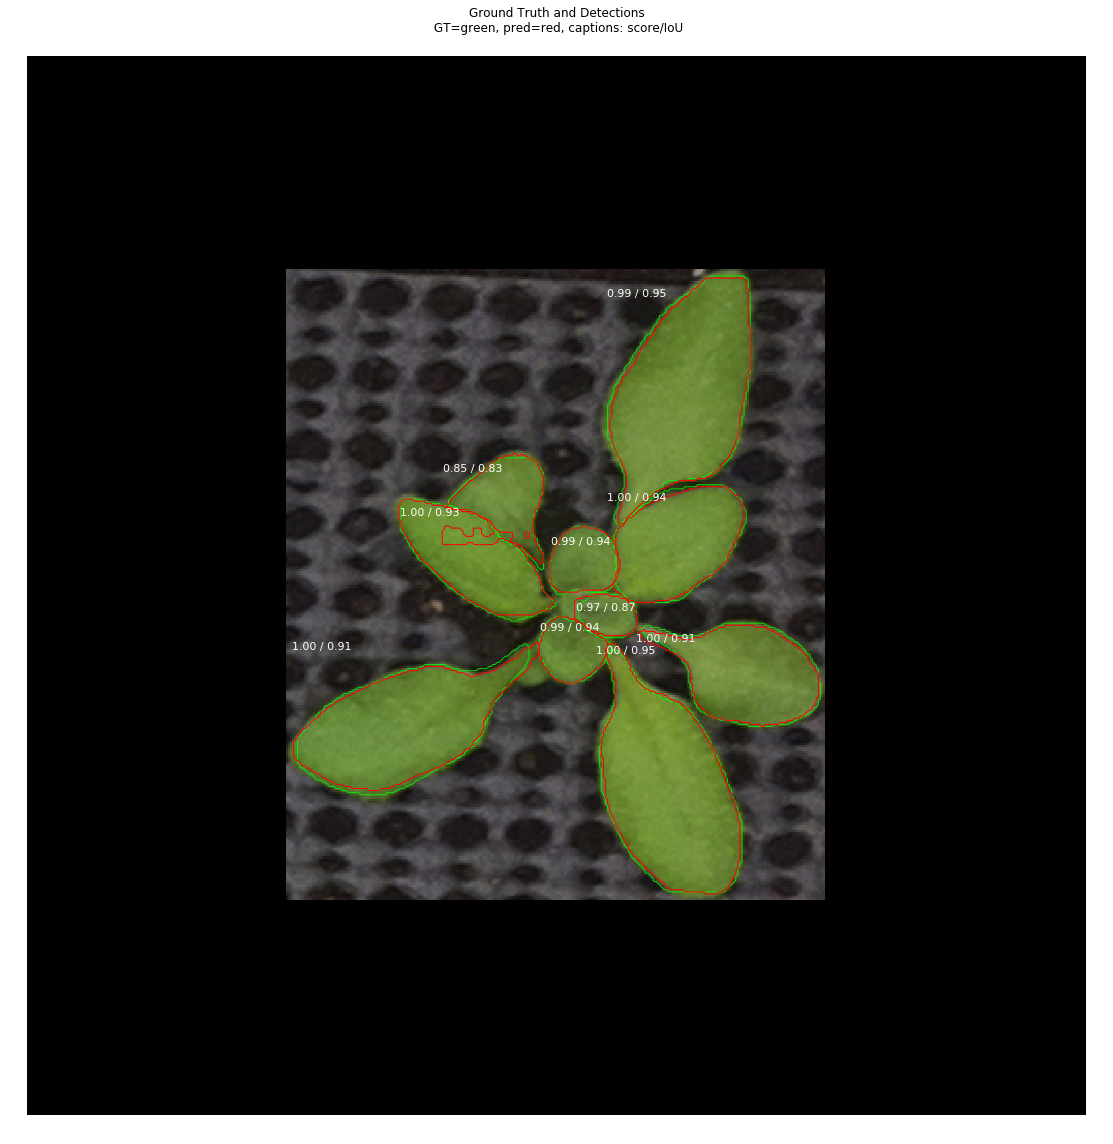

In [56]:
# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_test.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

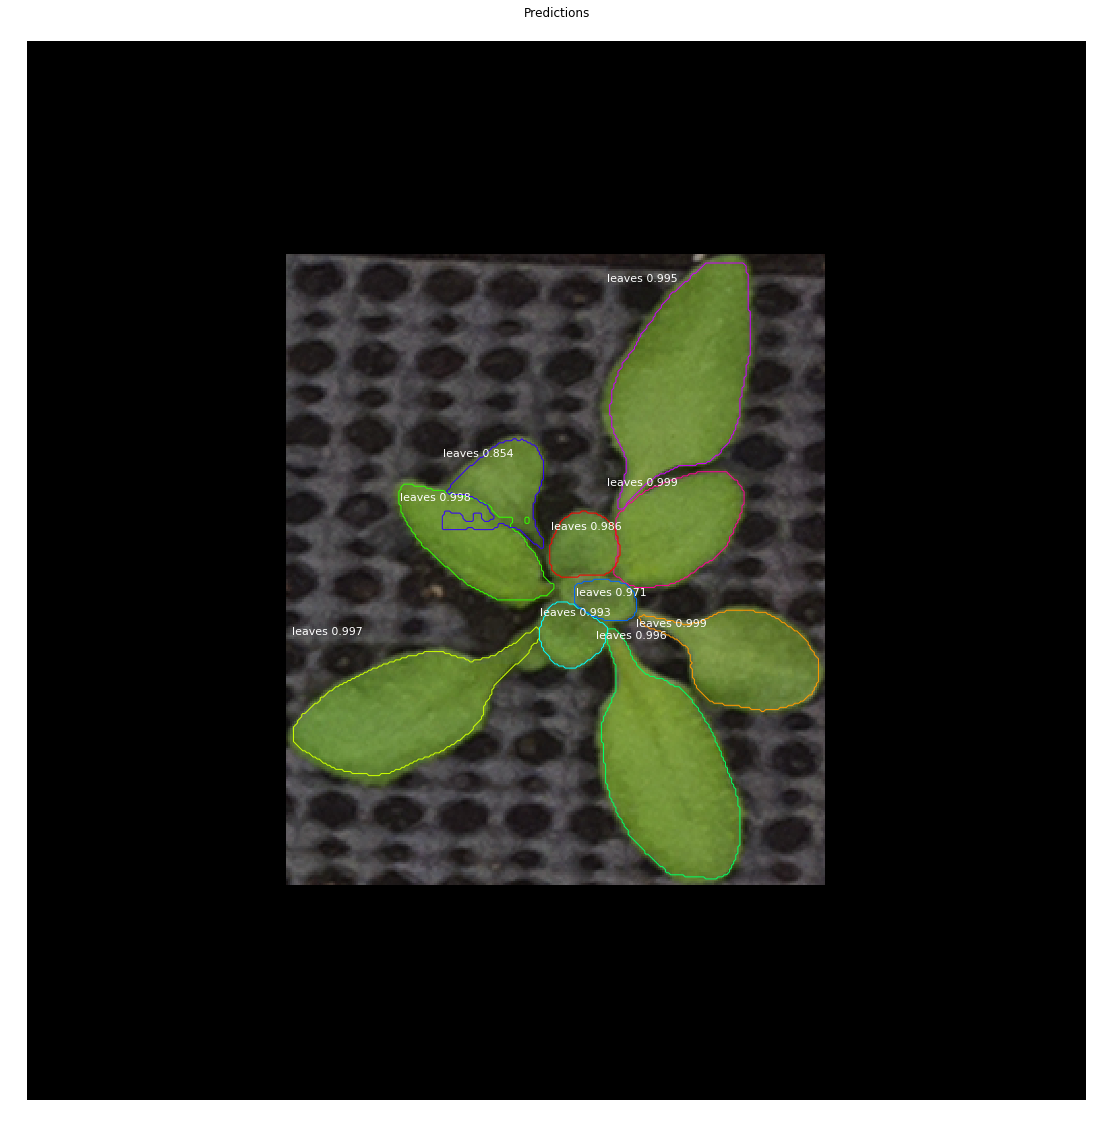

In [57]:
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

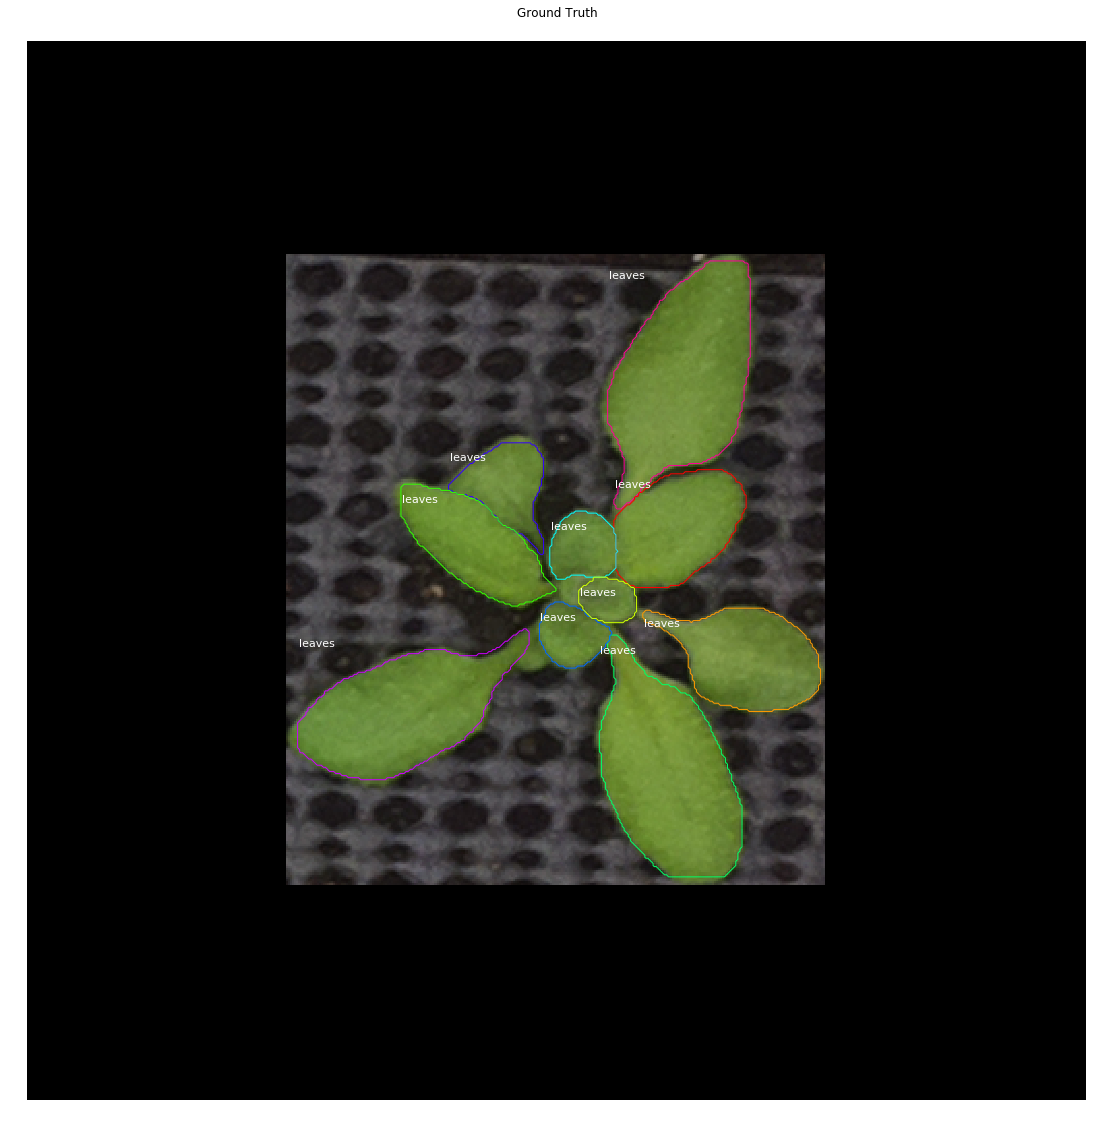

In [58]:
# Display Ground Truth only
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Ground Truth")

## Compute AP on Batch of Images
AP: average precision

In [60]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
#         results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        molded_images, image_metas, windows = model.mold_inputs([image])
        results = model.detect_molded(molded_images, image_metas, verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset_test, dataset_test.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [512 512   3]   AP: 0.00
  1 [512 512   3]   AP: 0.20
  2 [512 512   3]   AP: 0.87
  3 [512 512   3]   AP: 0.87
Mean AP overa 4 images: 0.4849


## Step by Step Prediction

### Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1. a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [61]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (65472, 4)            min:  -91.00000  max:  539.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -2.48218  max:    2.30909  float64
positive_anchors         shape: (11, 4)               min:  101.00000  max:  397.00000  int32
negative_anchors         shape: (245, 4)              min:   -8.00000  max:  515.00000  int32
neutral anchors          shape: (65216, 4)            min:  -91.00000  max:  539.00000  int32
refined_anchors          shape: (11, 4)               min:  106.00000  max:  404.00000  float32


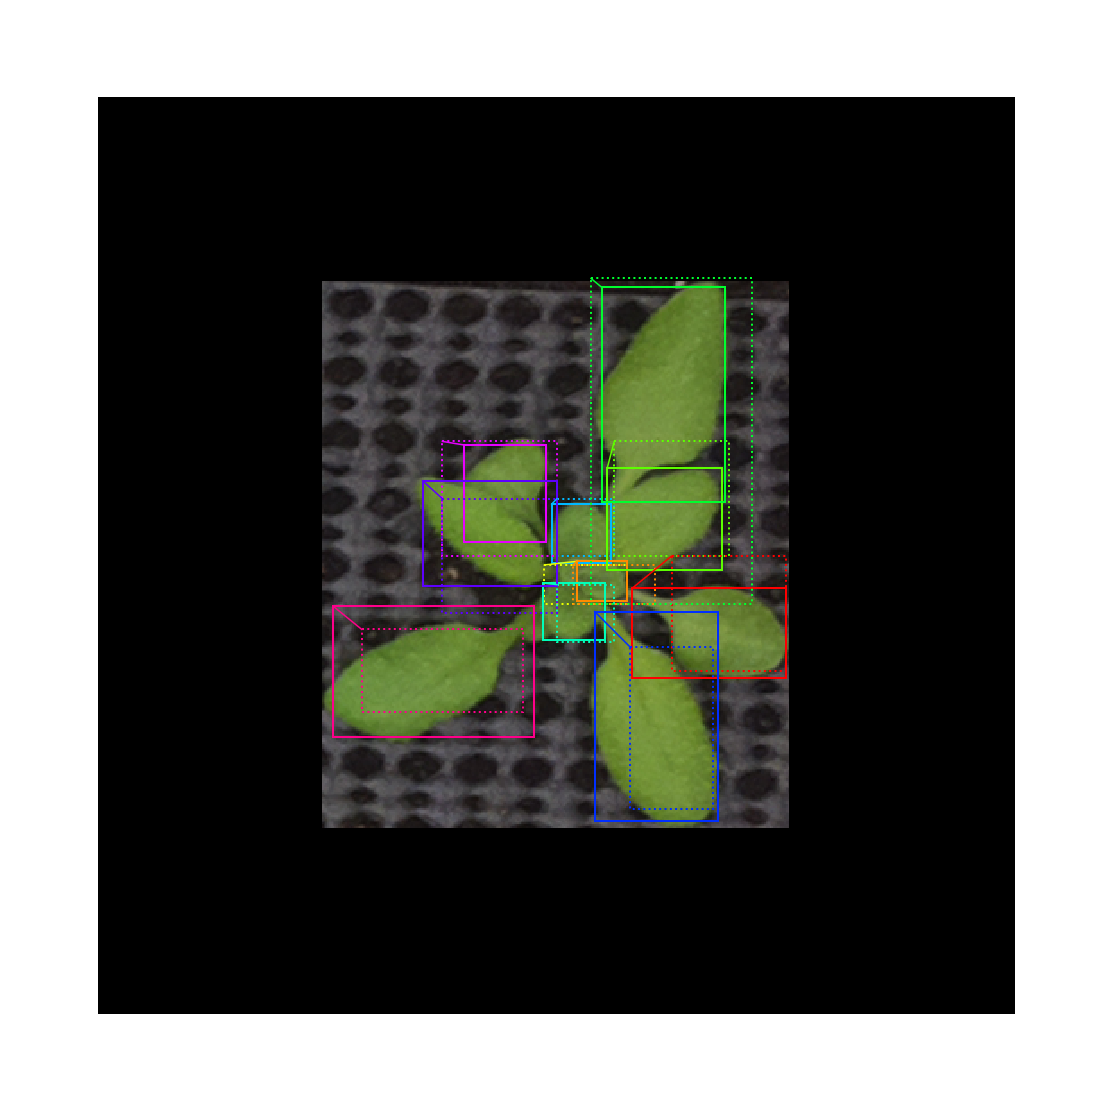

In [62]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions

In [63]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.17712  max:    1.05188  float32
refined_anchors          shape: (1, 6000, 4)          min:  -52.34292  max:   52.35702  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (809,)                min:    0.00000  max: 5523.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


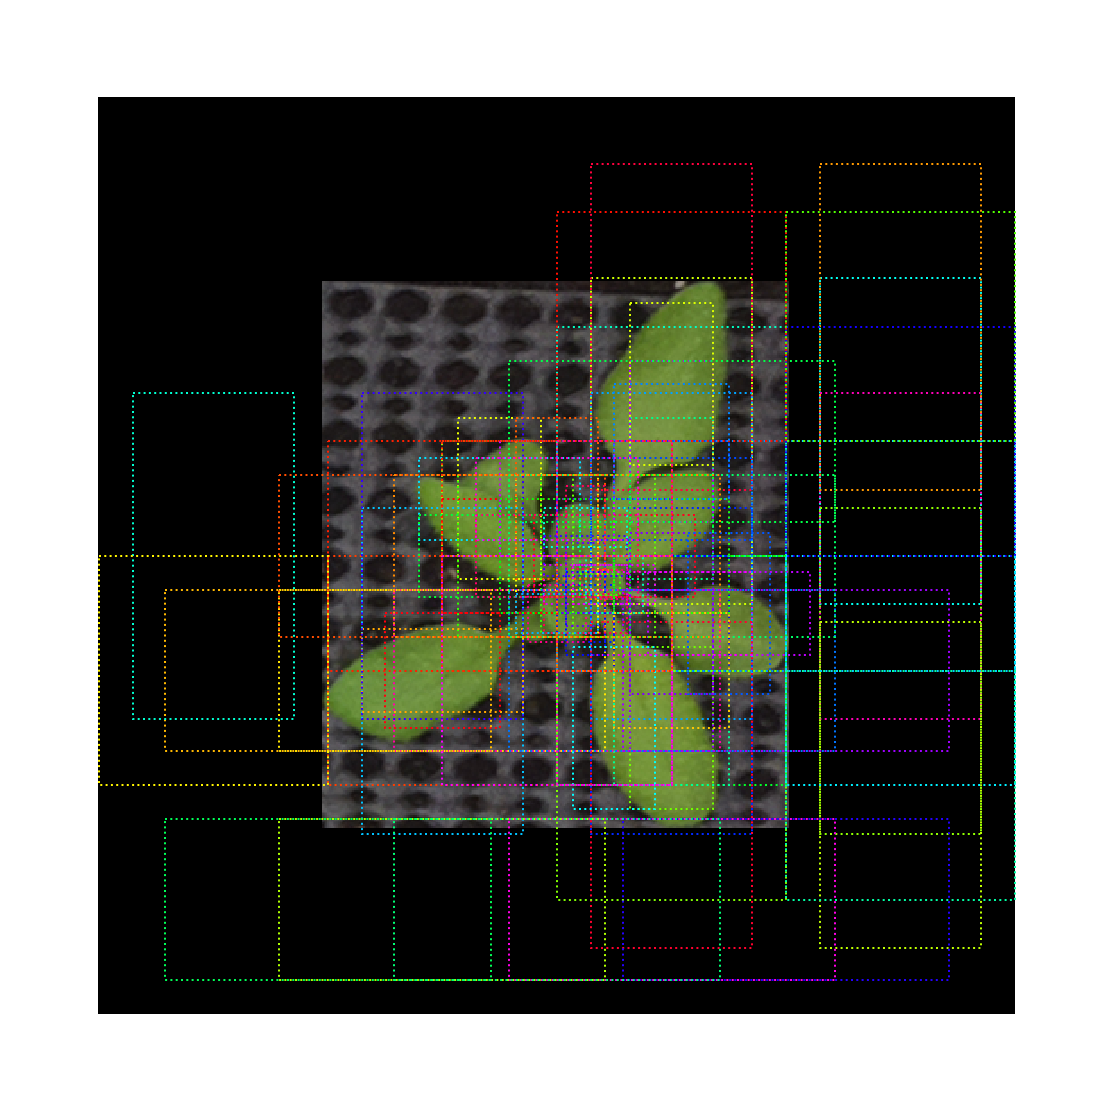

In [64]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

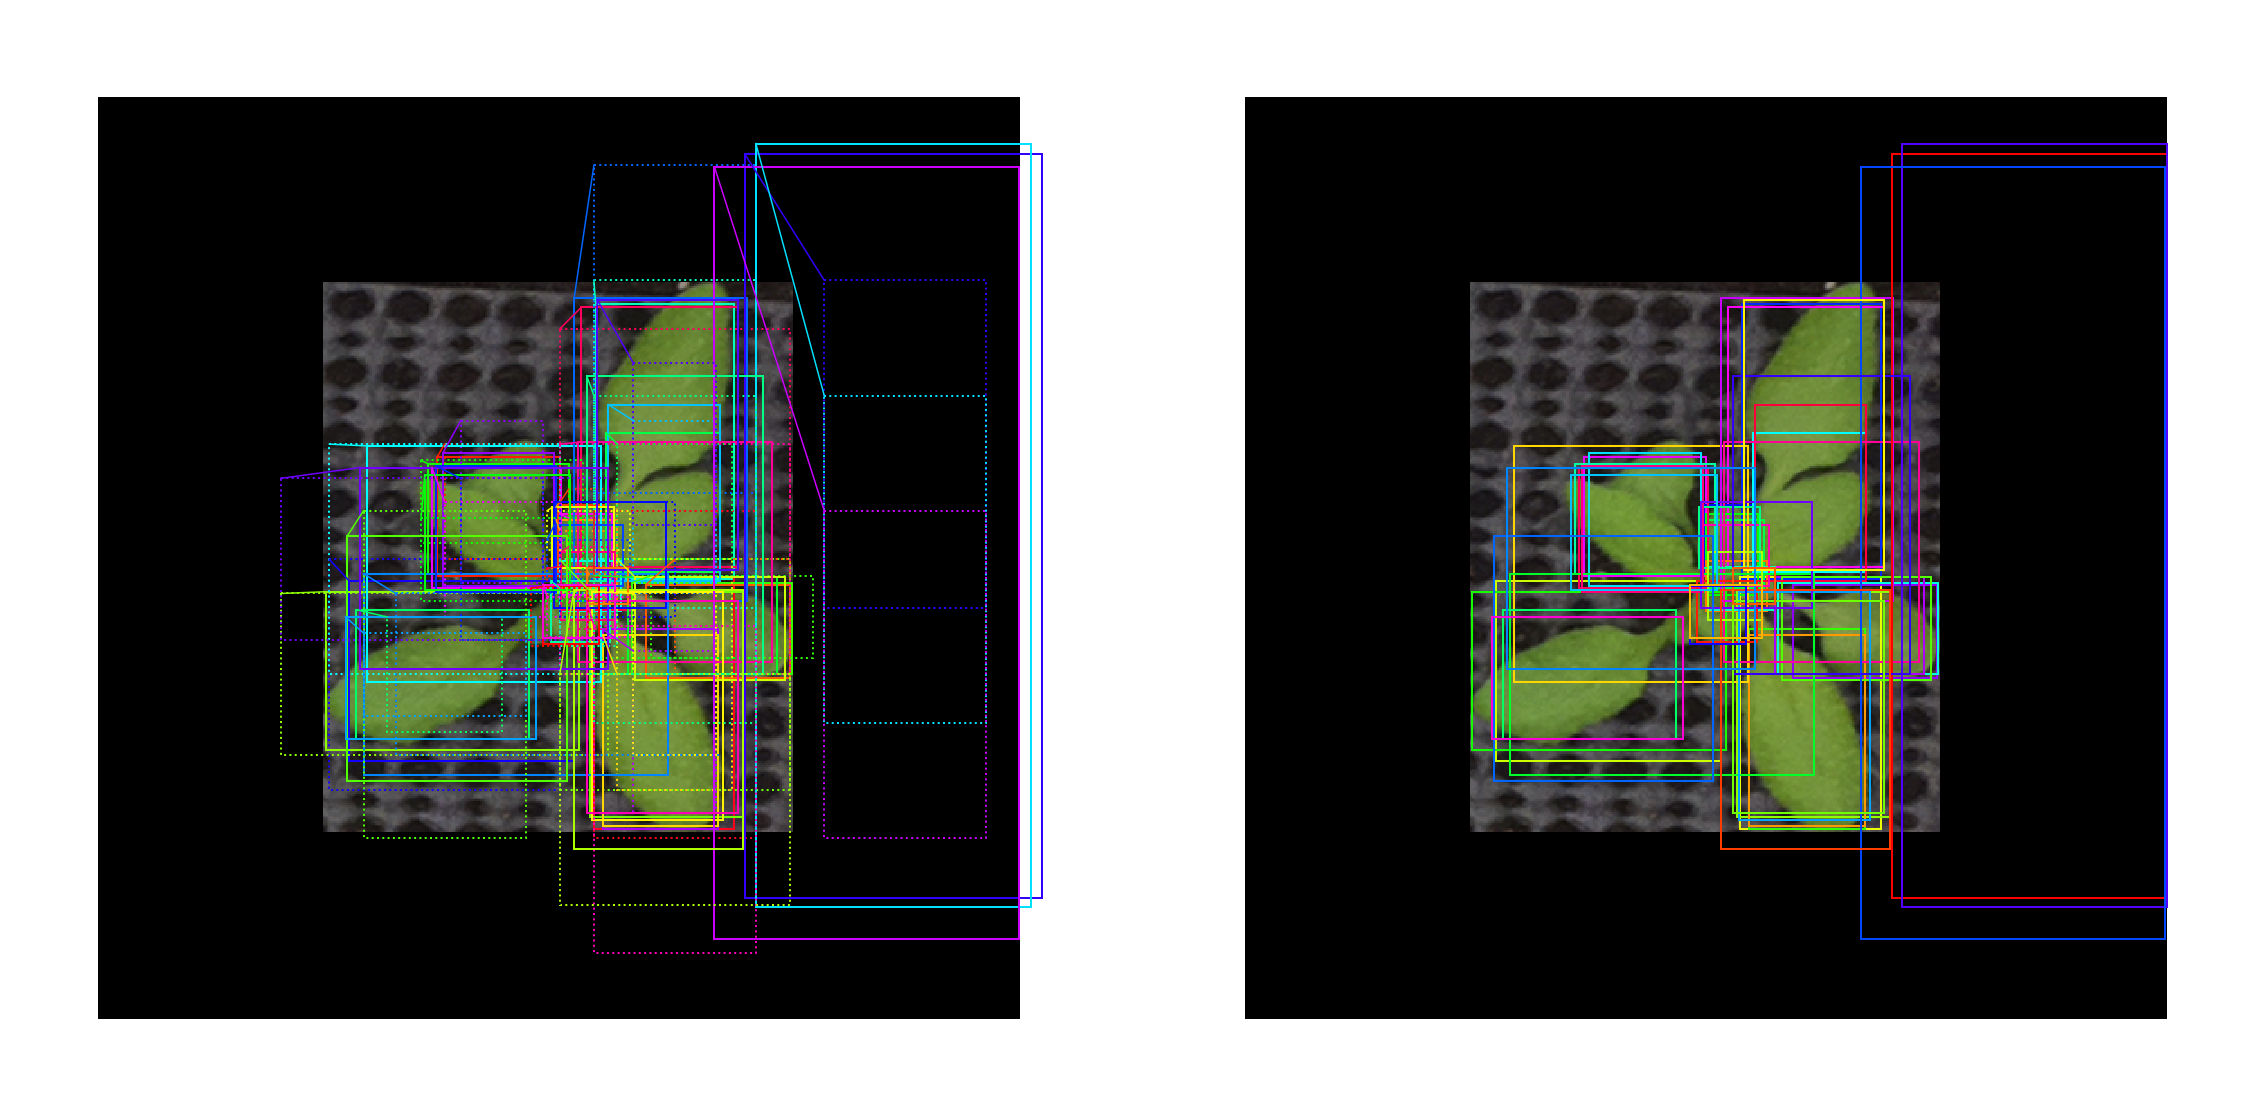

In [65]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

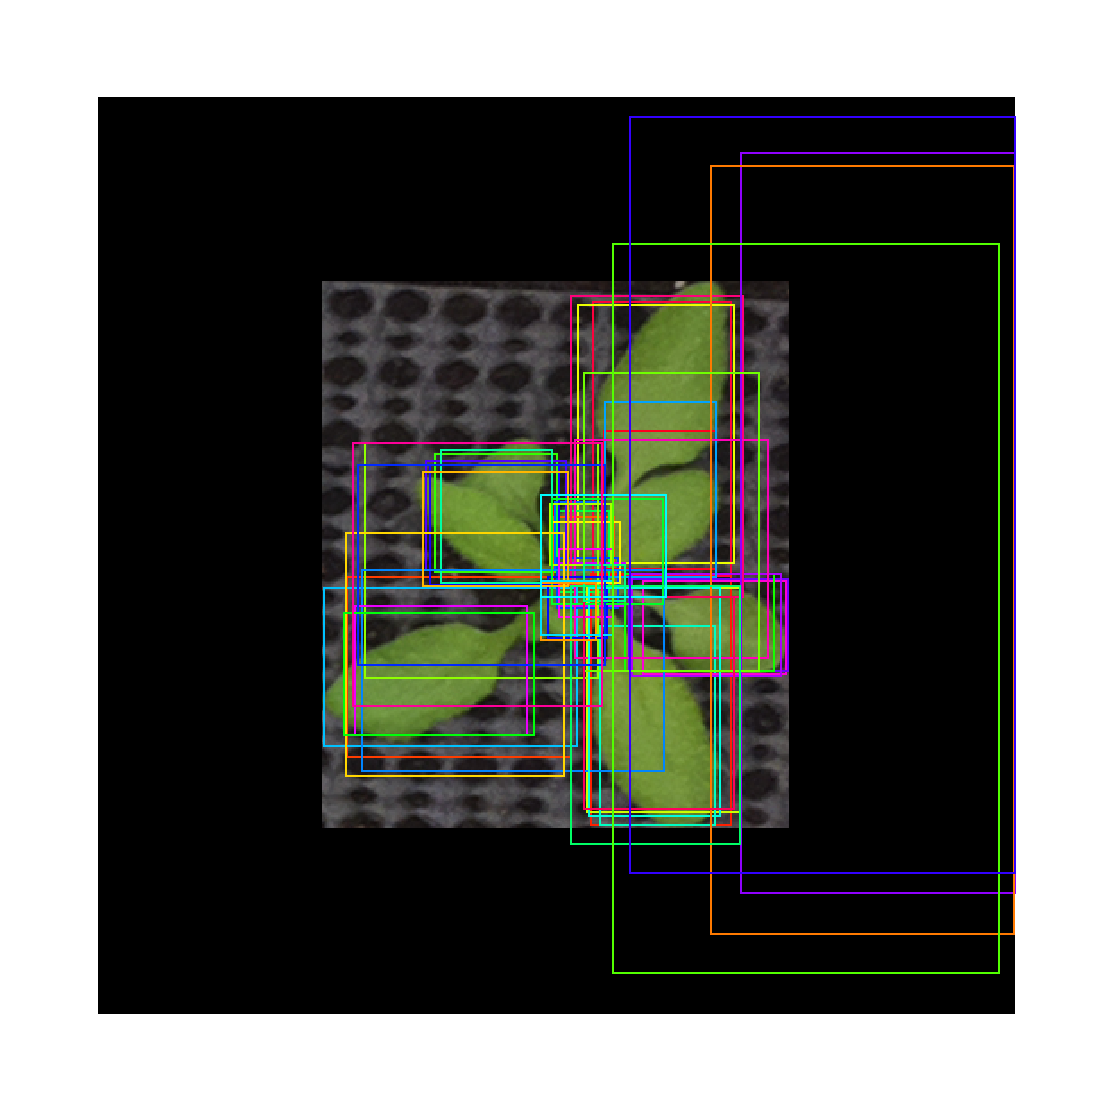

In [66]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

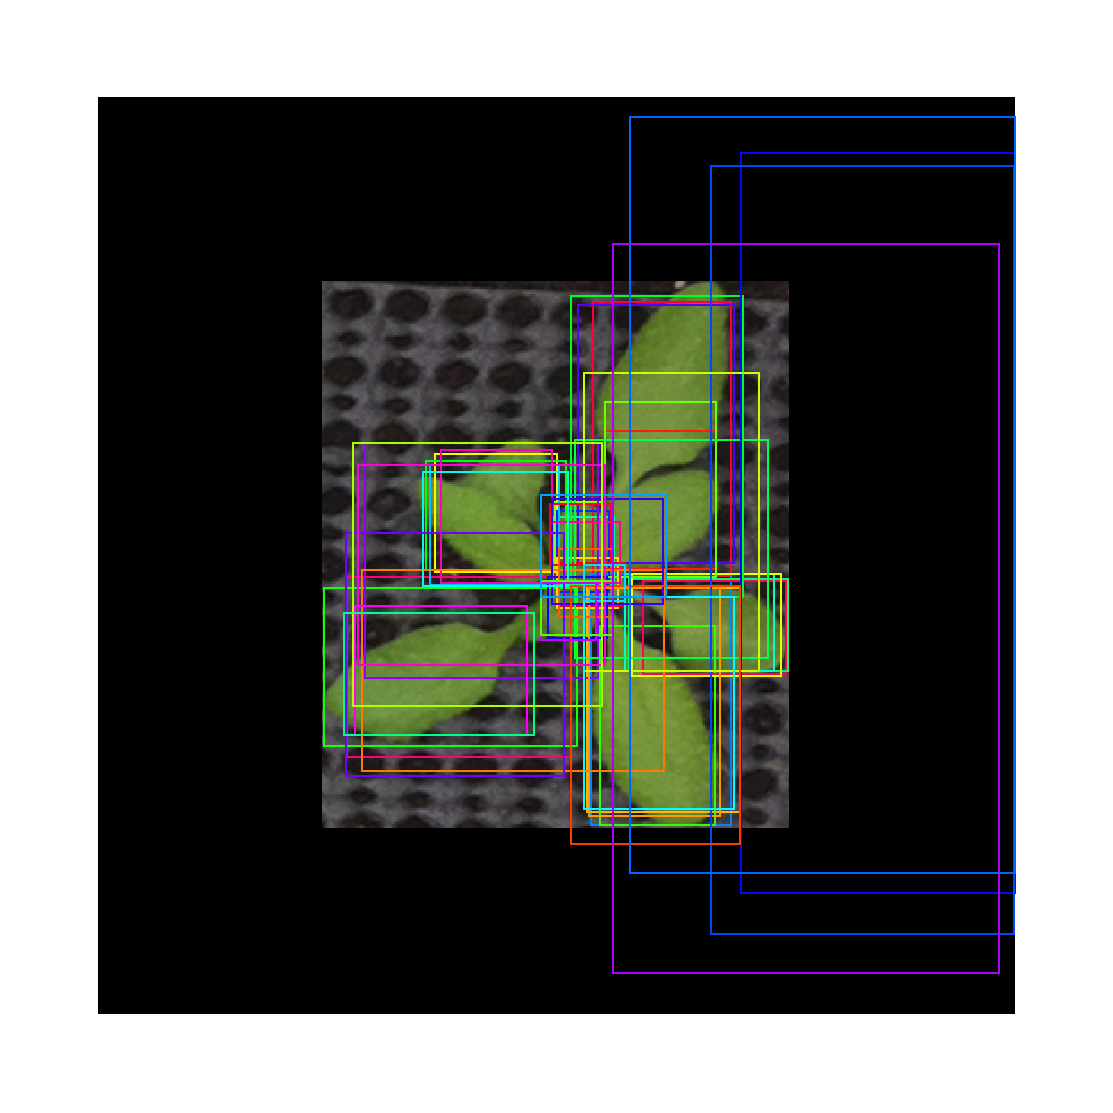

In [67]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

### Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classificaion

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [68]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.08317  max:    2.73528  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.99983  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


10 detections: ['leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves'
 'leaves' 'leaves']


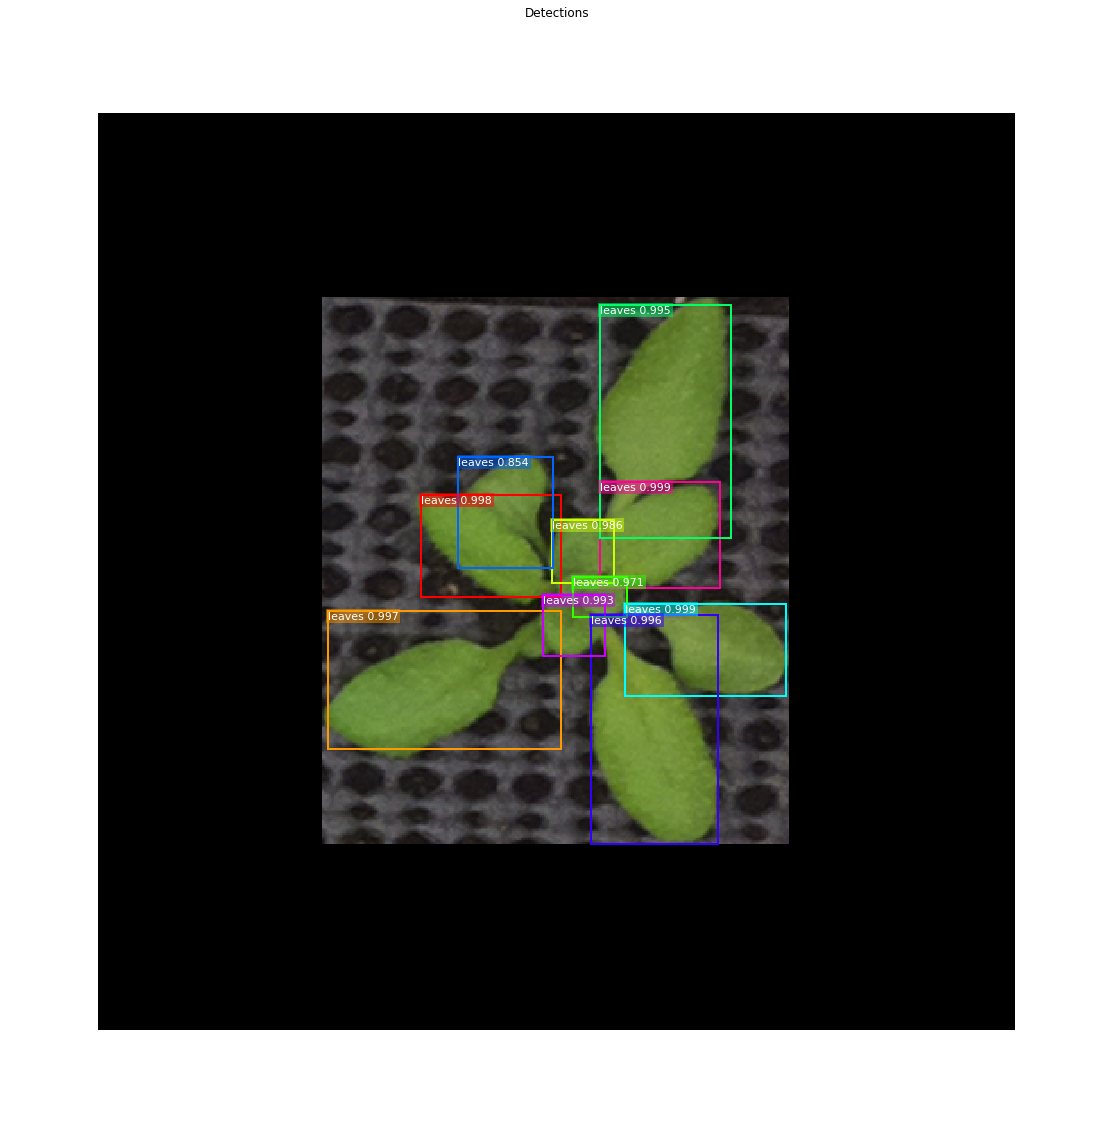

In [71]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_test.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_test.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [73]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_test.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
106 Positive ROIs
[('BG', 894), ('leaves', 106)]


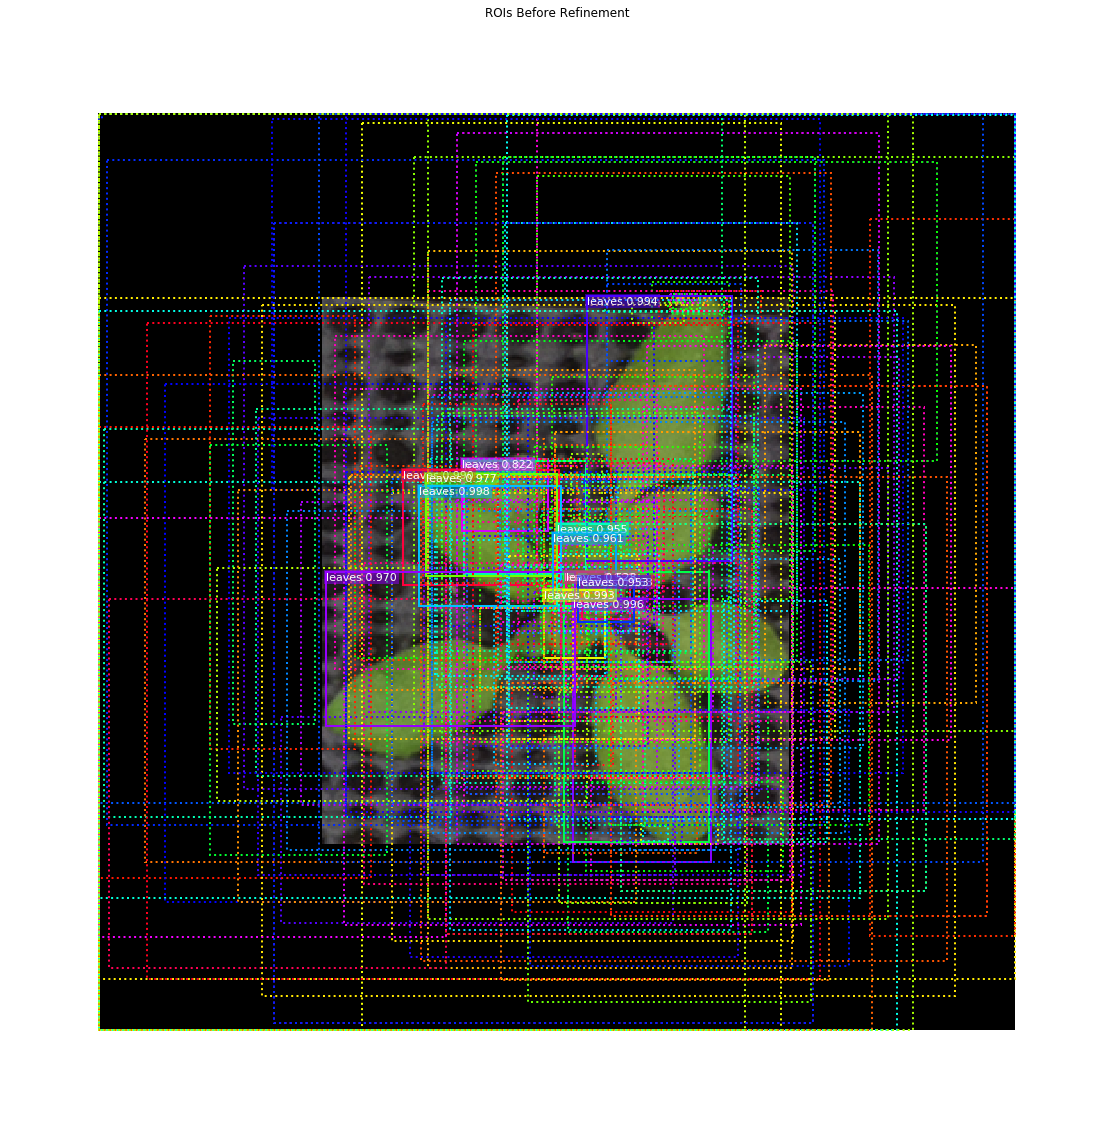

In [74]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_test.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.47004  max:    2.38239  float32
refined_proposals        shape: (1000, 4)             min:   -0.36103  max:    1.16385  float32


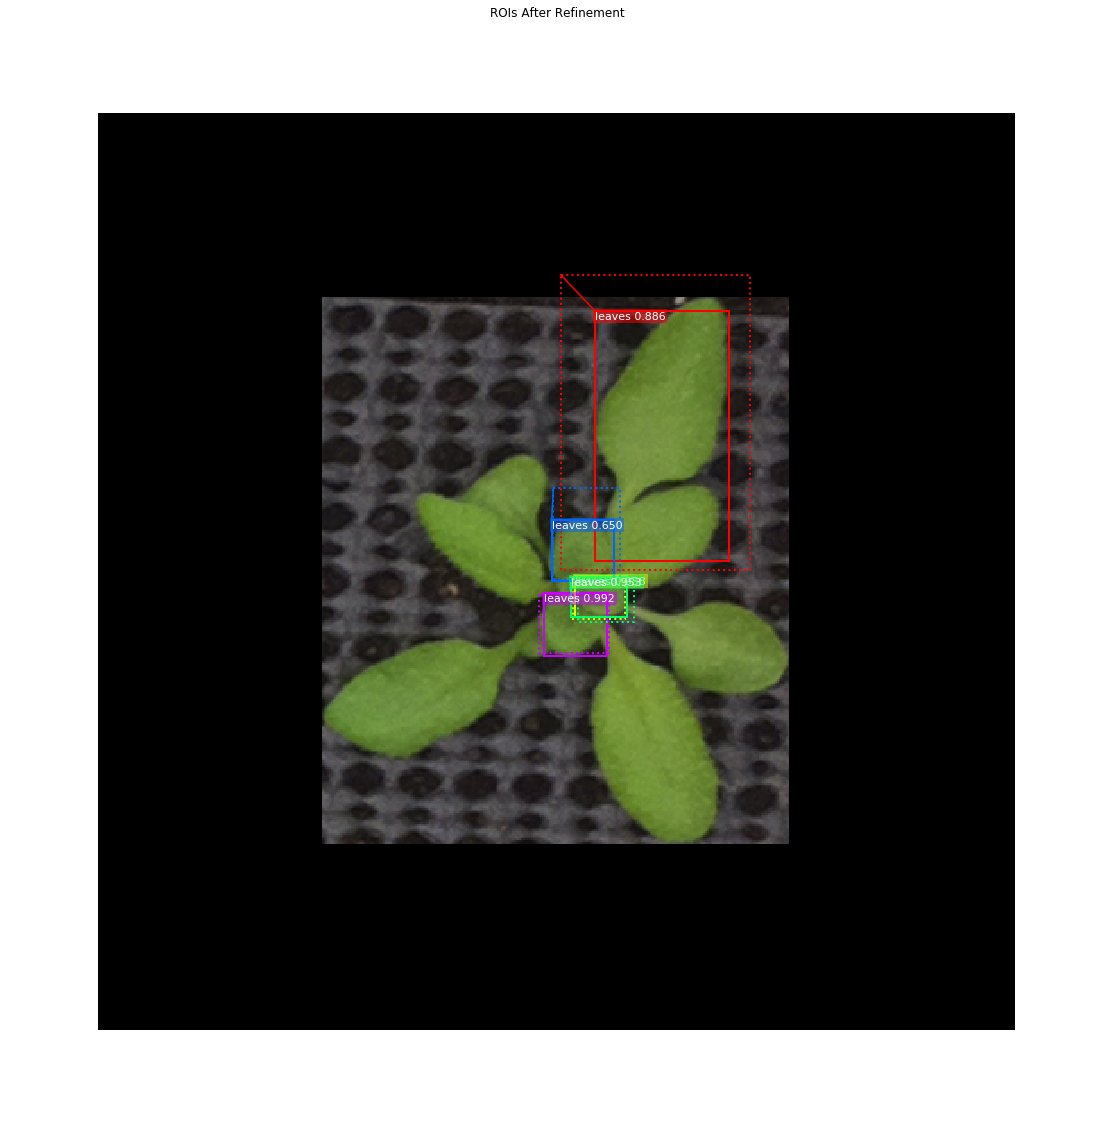

In [76]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_test.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [77]:
# Remove boxes classified as background

keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 106 detections:
[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  39
  41  42  43  44  45  46  47  50  51  52  54  55  56  59  61  62  65  67
  68  69  71  72  73  75  76  77  78  80  81  84  85  87  90  93  94  95
  97  99 100 102 104 107 109 118 120 124 125 126 127 128 129 130 132 133
 134 135 136 137 142 149 151 165 169 173 179 191 192 298 349 357]


In [78]:
# Remove low confidence detections 
# based on config.DETECTION_MIN_CONFIDENCE

keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.8 confidence. Keep 86:
[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  39
  42  43  44  46  47  50  51  52  54  55  56  59  61  62  65  67  68  69
  71  72  73  75  76  77  80  81  85  87  90  93  94  97  99 100 104 109
 118 124 125 127 129 130 132 133 137 142 149 169 179 349]


#### Per-Class Non-Max Suppression

In [80]:
# Apply per-class non-max suppression 
# based on config.DETECTION_NMS_THRESHOLD
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_test.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

leaves                : [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  39
  42  43  44  46  47  50  51  52  54  55  56  59  61  62  65  67  68  69
  71  72  73  75  76  77  80  81  85  87  90  93  94  97  99 100 104 109
 118 124 125 127 129 130 132 133 137 142 149 169 179 349] -> [ 10  37  14   4  19  29  39   2 104  90]

Kept after per-class NMS: 10
[  2   4  10  14  19  29  37  39  90 104]


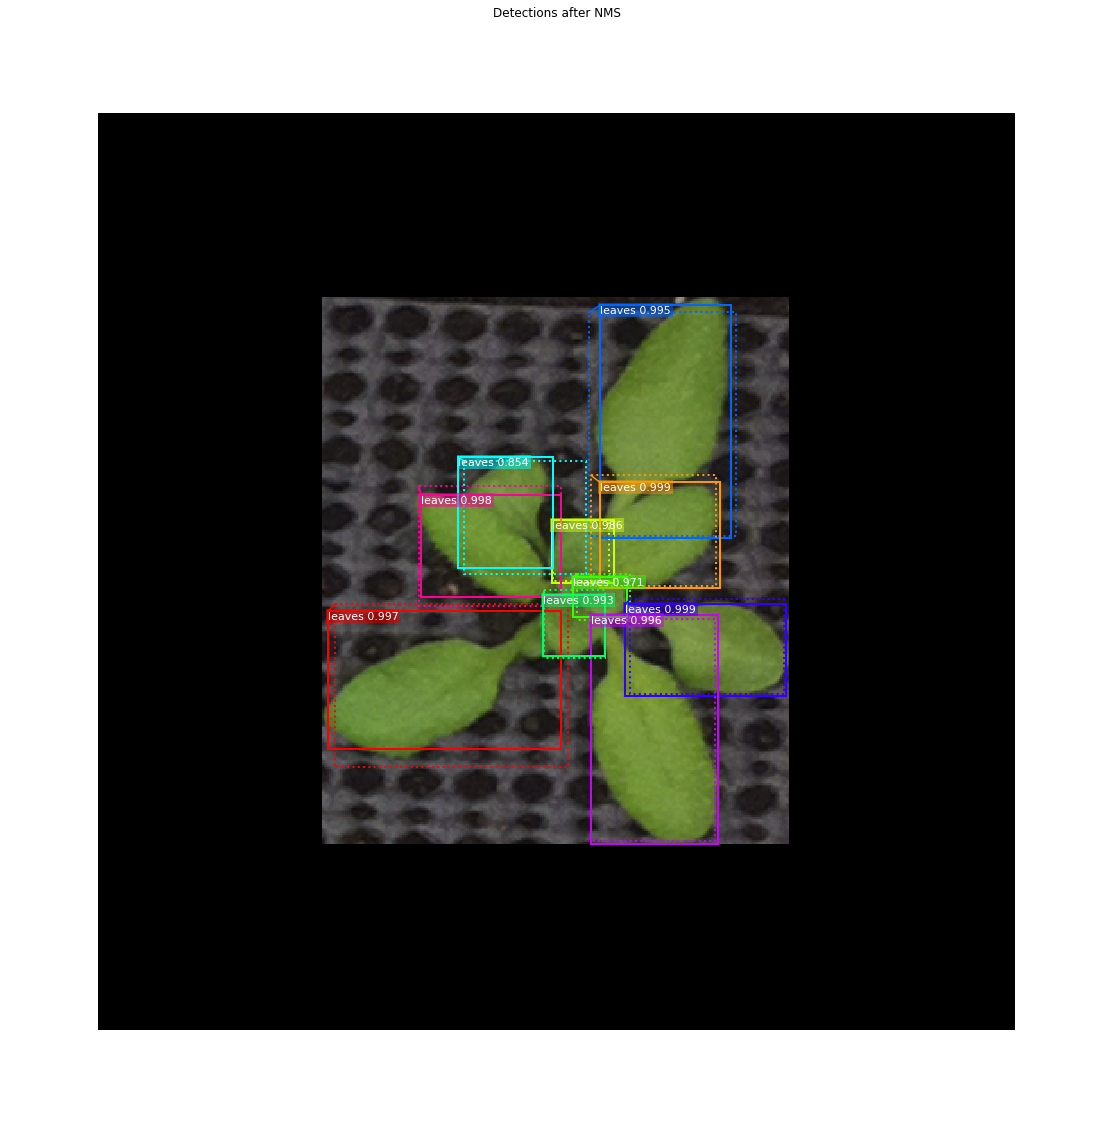

In [81]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_test.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

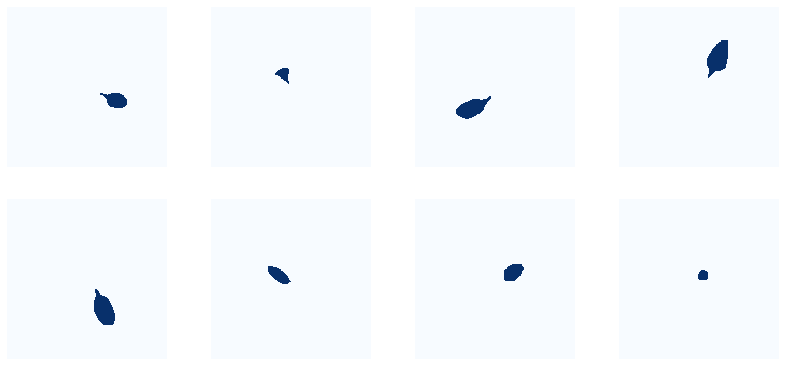

In [82]:
limit = 8
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [83]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_test.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.99983  float32
10 detections: ['leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves' 'leaves'
 'leaves' 'leaves']


In [84]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (10, 28, 28)          min:    0.00000  max:    0.99983  float32
det_masks                shape: (10, 512, 512)        min:    0.00000  max:    1.00000  bool


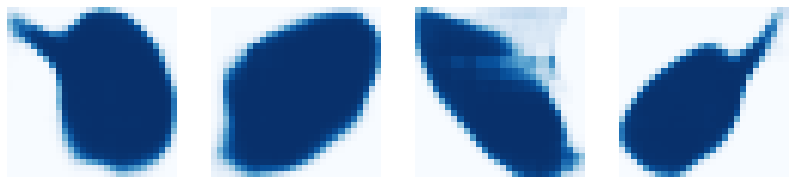

In [85]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

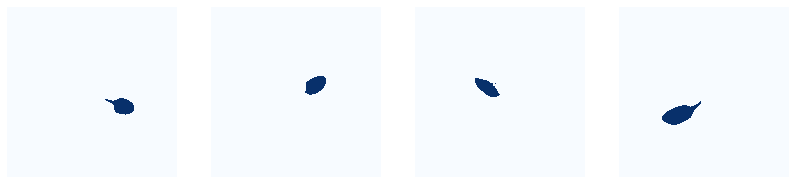

In [86]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [87]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:   47.20000  float32
res2c_out                shape: (1, 128, 128, 256)    min:   -0.00000  max:   24.53939  float32
res3c_out                shape: (1, 64, 64, 512)      min:   -0.00000  max:   26.62964  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -16.19412  max:   74.66190  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


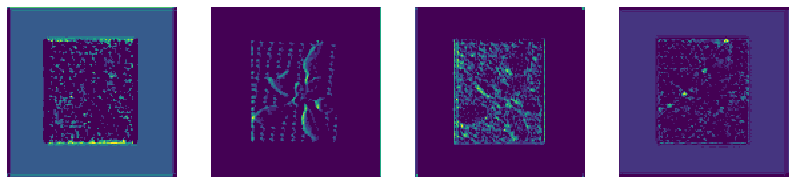

In [88]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [ ]:
import pickle as pkl
name1 = "/shares/mgehan_share/hsheng/projects/URoLE/ground_truth/plant11/10.9.1.241_pos-165-003-020_2019-10-20-12-05.pkl"

loaded1 = pkl.load(open(name1, "rb"))

In [ ]:
loaded1['masks'].shape


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(loaded1['masks'][:,:,1])

In [ ]:
from plantcv import plantcv as pcv
# imgname = "/shares/mgehan_share/hsheng/projects/URoLE/new_crop/crop_results/10.9.1.241_wtCol_lowCo2_BR5/auto_crop/plant11/10.9.1.241_pos-165-003-020_2019-10-20-09-05.png"
# imgname = "/shares/mgehan_share/hsheng/projects/URoLE/new_crop/crop_results/10.9.1.241_wtCol_lowCo2_BR5/auto_crop/plant11/hard_crop/10.9.1.241_pos-165-003-020_2019-10-20-09-05_.png"
# imgname = "/shares/mgehan_share/hsheng/projects/URoLE/crop/crop_results/10.9.1.241_wtCol_lowCo2_BR5/plant11/combined/10.9.1.241_pos-165-003-020_2019-10-20-09-05.png"
img, _, _ = pcv.readimage(imgname)

In [ ]:
img.shape

In [ ]:
pcv.plot_image(img)

In [ ]:
masked = pcv.apply_mask(img, loaded1['masks'][:,:,1],mask_color="black")
pcv.plot_image(masked)